# SPA - J = 0 to 1
Simulating the SPA1, i.e. transferring molecules from J = 0 to J = 0 using microwave driven adiabatic passage.

## Import packages

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use(["seaborn-dark"])
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = 'serif'

import numpy as np

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from centrex_TlF.transitions import calculate_transition_frequency
from state_prep.electric_fields import ElectricField, E_field_ring
from state_prep.hamiltonians import SlowHamiltonian, SlowHamiltonianOld
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [4]:
trajectory = Trajectory(Rini = np.array((0,0,-100e-3)), Vini = np.array((0,0,200.)), zfin = 200e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [5]:
#Define positions for centers of ring electrodes (in m)
electrode_offset = 0.0
z1 = -85.725e-3  + electrode_offset
z2 = 85.725e-3 + electrode_offset

#Define voltages on the rings
V1 = 5e3
V2 = V1*0.07

#Define a quickly decaying function to simulate adding shielding between state prep region and detection region
decay_function = lambda R, Z0, l: np.exp(-0.5*((R[2]-Z0)*float(R[2]>Z0)/l)**2)
decay_tanh = lambda R,Z0,l,z_shield: .5*(1-np.tanh((R[2]-Z0)/l))

#Define electric field as function of position
z_shield = 0.085
l_decay = 0.02
z0 = 116.4/1e3

E_R = lambda R: ((E_field_ring(R, z0 = z1, V = V1)
                        + E_field_ring(R, z0 = z2, V = V2))*decay_tanh(R,z0,l_decay,z_shield))

electric_field = ElectricField(E_R, trajectory.R_t)

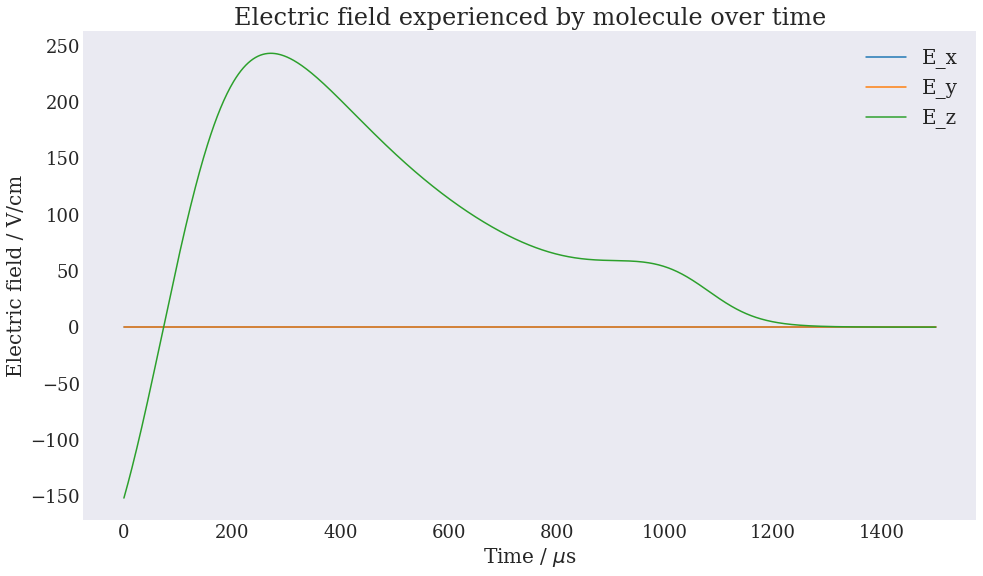

In [6]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [7]:
B = np.array((0,0,1e-3))
# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3,1)) * np.ones(R.shape)

magnetic_field = MagneticField(B_R, R_t = trajectory.R_t)

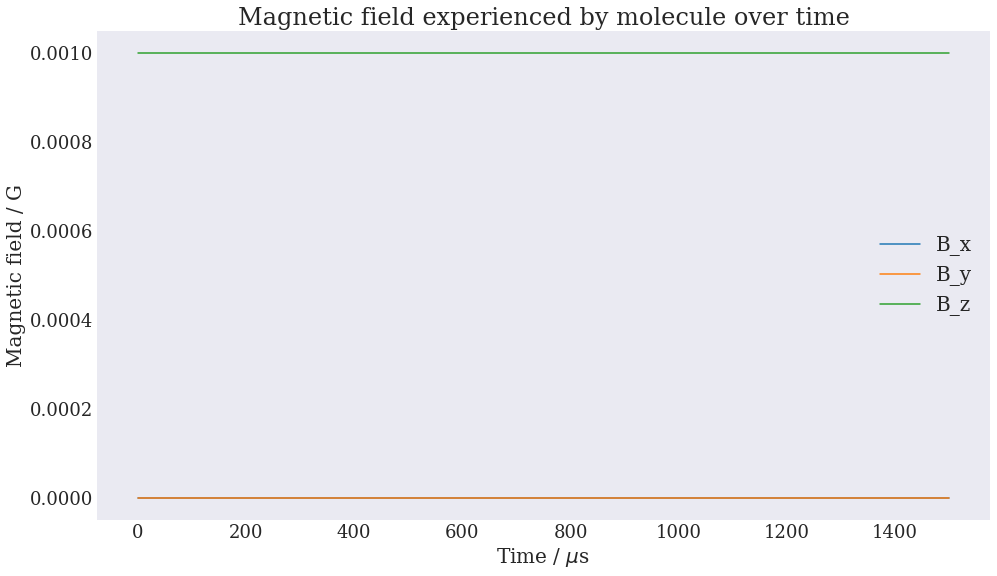

In [8]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [9]:
#Define some useful approximate states
J0_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_p = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')

J0_triplet_m = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [10]:
#Define some useful approximate states
J1_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_p = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')

J1_triplet_m = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')

final_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [11]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)
# hamiltonian = SlowHamiltonianOld(0, 3, trajectory, electric_field, magnetic_field, '../hamiltonians/TlF_X_state_hamiltonian0to3_2020_03_03.pickle')

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J = 0 to 1 microwaves

#### Define states

In [12]:
state1 = J0_singlet
state2 = J1_singlet

#### Center position

In [13]:
R0 = np.array((0.00,0,0.0))

In [14]:
R0.shape

(3,)

#### Polarization:

In [15]:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
P_R = lambda R: p_z

# Define k-vector
k = np.array((1,0,0))

pol = Polarization(P_R, k, f_long = 1)

#### Frequency
Calculate the microwave frequency between specified states at a specific point

In [16]:
muW_freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)

In [17]:
print(f"Transition frequency at center of microwaves: {muW_freq/1e9:.5f} GHz")

Transition frequency at center of microwaves: 13.33900 GHz


#### Intensity profile:

In [18]:
# Define a Gaussian intensity profile
intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)

#### Define MicrowaveField

In [19]:
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq, hamiltonian.QN) 

#### Power:
Calculate the power required for the microwaves to have a given Rabi rate for the main polarization at a specific position.

In [20]:
R0

array([0., 0., 0.])

In [21]:
mf01.calculate_microwave_power(state1, state2, 2*np.pi*70e3, R0)

In [22]:
mf01.intensity.power

(9.694468771616957e-05+0j)

### Plot intensity profile
Check that the longitudinal polarization appears correctly

C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


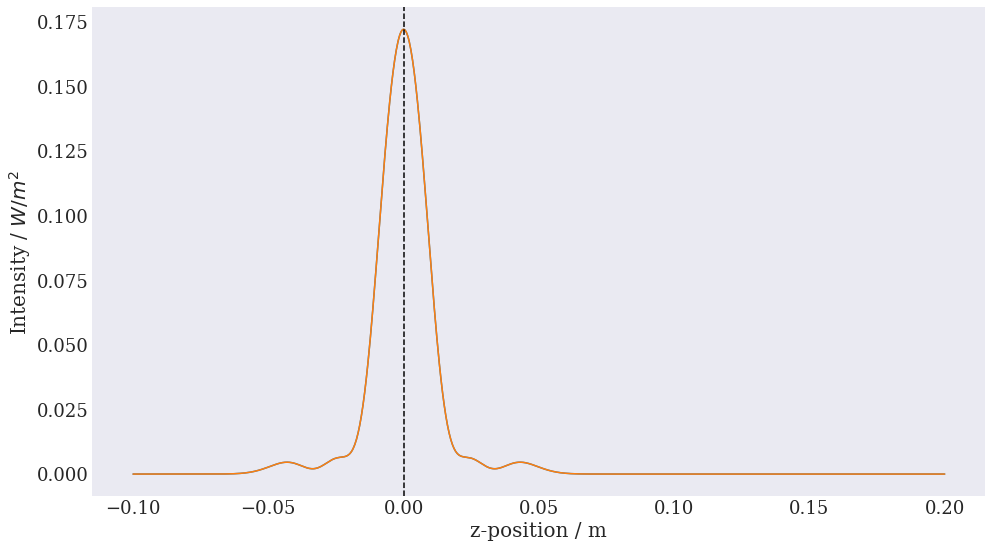

In [23]:
zs = np.linspace(-0.1, 0.075, 1000)
t_array = np.linspace(0, trajectory.get_T(), 1000)
Rs = np.array([trajectory.R_t(t) for t in t_array])
intensities_R = np.array([mf01.intensity.I_R(trajectory.R_t(t)) for t in t_array])
intensities = np.array([mf01.intensity.I_R(np.array([0,0,z])) for z in Rs[:,2]])


fig, ax = plt.subplots()
ax.plot(Rs[:,2],intensities_R)
ax.plot(Rs[:,2],intensities)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Intensity / $W/m^2$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


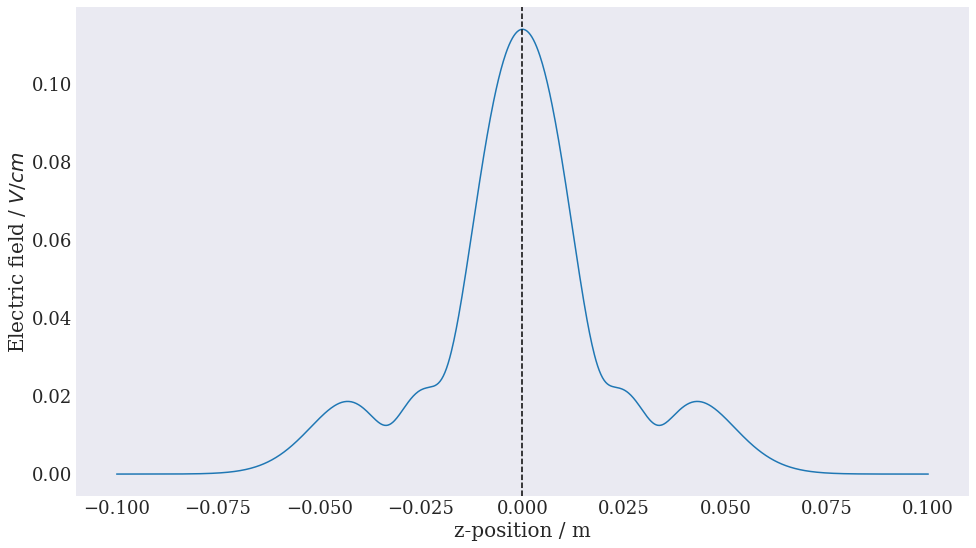

In [24]:
zs = np.linspace(-0.1, 0.1, 1000)
E_mags = np.array([mf01.intensity.E_R(np.array((0.,0.,z))) for z in zs])

fig, ax = plt.subplots()
ax.plot(zs,E_mags)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Electric field / $V/cm$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

### Plot polarization components as function of position
Check that the longitudinal polarization appears correctly

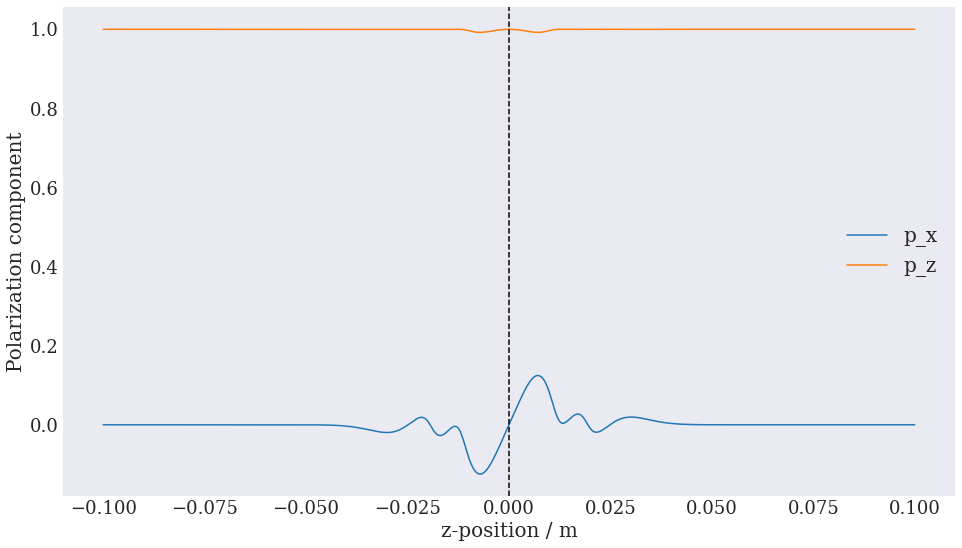

In [25]:
zs = np.linspace(-0.1, 0.1, 1000)
pols = np.array([mf01.polarization.p_R(np.array((0.,0.,z)), mf01.intensity, freq=muW_freq) for z in zs])

fig, ax = plt.subplots()
ax.plot(zs, np.imag(pols[:,0]), label='p_x')
# ax.plot(zs, pols[:,1], label='p_y')
ax.plot(zs, np.real(pols[:,2]), label='p_z')
ax.legend()
ax.set_xlabel("z-position / m")
ax.set_ylabel("Polarization component")
ax.axvline(x = R0[2], ls ='--', c = 'k')

### Define list of microwave fields

In [26]:
microwave_fields = [mf01]

In [27]:
np.diag(mf01.D)/(2*np.pi)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.33389968e+10, -1.33389968e+10, -1.33389968e+10, -1.33389968e+10,
       -1.33389968e+10, -1.33389968e+10, -1.33389968e+10, -1.33389968e+10,
       -1.33389968e+10, -1.33389968e+10, -1.33389968e+10, -1.33389968e+10,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [28]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian, microwave_fields)

In [46]:
R0 = np.array([0,0,-0.02])
freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
mf01.set_frequency(freq - 0e6)
mf01.set_position(R0)

mf01.calculate_microwave_power(state1, state2, 2*np.pi*70e3, R0)

In [47]:
result = simulator.run(N_steps = 5000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:17<00:00, 290.35it/s]


## Plot results

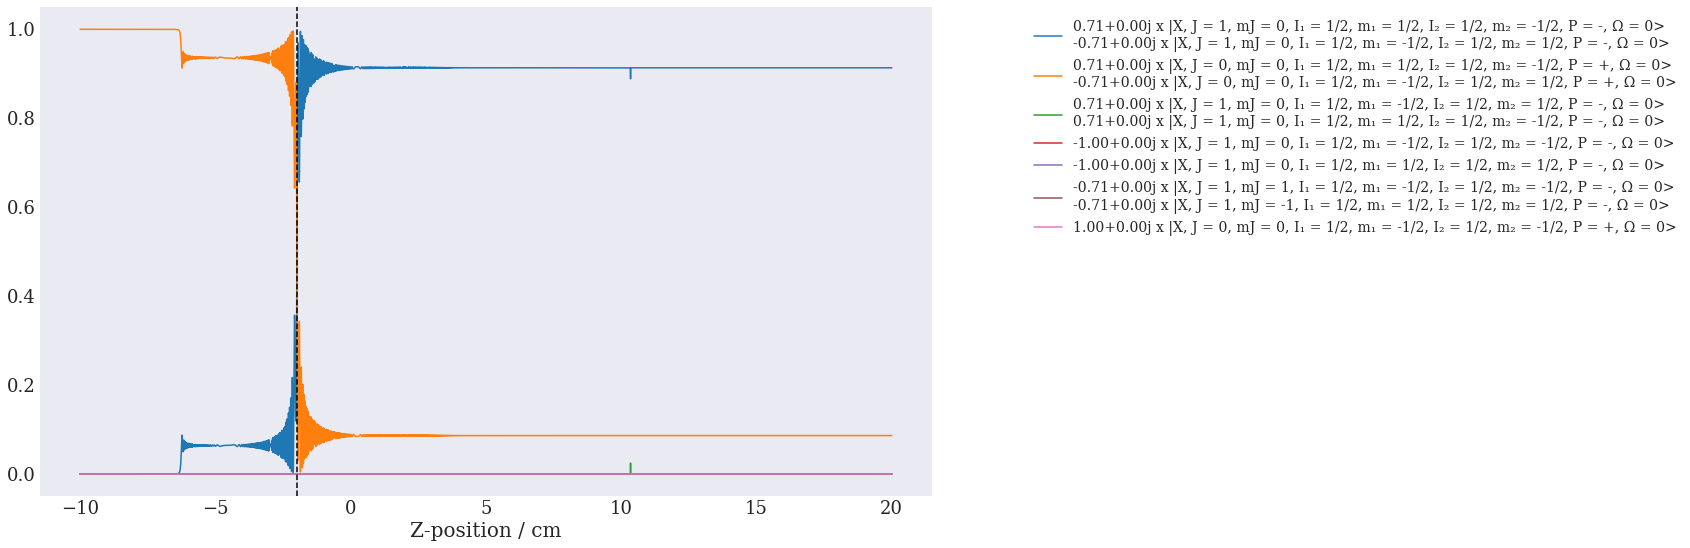

In [48]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, position = True)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))
ax.axvline(x = R0[2]*1e2, ls ='--', c = 'k')

## Convert final state vectors to coupled basis

In [549]:
def prob_F(state: centrex_TlF.State, F: float) -> float:
    """
    Calculates probability that molecule is found in state with given F.
    """
    prob = 0
    for amp, basis_state in state.data:
        prob += np.abs(amp)**2 *(basis_state.F == F)
        
    return prob

In [40]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_singlet = result.psis[-1,0,:]
final_state_singlet = (vector_to_state(final_state_vec_singlet, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 0, mJ = 0, S = 0 > ->")
final_state_singlet.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 1: {prob_F(final_state_singlet, 1):.3f}")

#Starting in triplet_m
print('\n'+20*'*')
final_state_vec_triplet_m = result.psis[-1,1,:]
final_state_triplet_m = (vector_to_state(final_state_vec_triplet_m, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 0, mJ = 0, S = 1, mS = -1 >  ->")
final_state_triplet_m.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_m, 2):.3f}")


#Starting in triplet_0
print('\n'+20*'*')
final_state_vec_triplet_0 = result.psis[-1,2,:]
final_state_triplet_0 = (vector_to_state(final_state_vec_triplet_0, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 0, mJ = 0, S = 1, mS = 0 >  ->")
final_state_triplet_0.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_0, 2):.3f}")


#Starting in triplet_p
print('\n'+20*'*')
final_state_vec_triplet_p = result.psis[-1,3,:]
final_state_triplet_p = (vector_to_state(final_state_vec_triplet_p, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("|J = 0, mJ = 0, S = 1, mS = 1 >  ->")
final_state_triplet_p.make_real().print_state(probabilities=True)
print(f"\nProbability of F = 2: {prob_F(final_state_triplet_p, 2):.3f}")

|J = 0, mJ = 0, S = 0 > ->
+0.9279+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0316+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0316+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

Probability of F = 1: 0.937

********************
|J = 0, mJ = 0, S = 1, mS = -1 >  ->
+0.9621+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0311+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

Probability of F = 2: 0.968

********************
|J = 0, mJ = 0, S = 1, mS = 0 >  ->
+0.9897+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

Probability of F = 2: 0.999

********************
|J = 0, mJ = 0, S = 1, mS = 1 >  ->
+0.9621+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0311+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

Prob

## Plot coupling strength

In [155]:
coupling_plotter = CouplingPlotter([(J0_singlet, J1_triplet_p)], hamiltonian, electric_field, result.microwave_fields[0], result.t_array)

C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


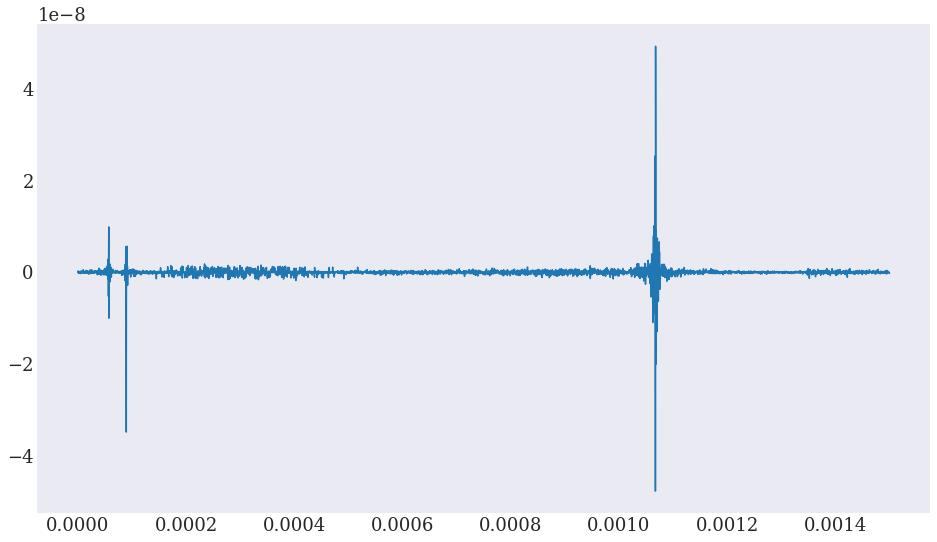

In [156]:
coupling_plotter.plot_coupling_strengths()